In [50]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Point

## Load data

### Base species list (defining the taxonomic unit used here)


In [51]:
sp_base_list = pd.read_csv("data/sp_base_list.csv")

# Overwrite map_index with match_map_index where match_map_index is not NaN
sp_base_list["map_index"] = (
    sp_base_list["match_map_index"].combine_first(sp_base_list["map_index"]).astype(int)
)

sp_base_list.sort_values(by="map_index")

# Drop the match_map_index column
sp_base_list = sp_base_list.drop(columns=["match_map_index"])

### Load eBird species list


In [52]:
sp_ebird_list = pd.read_csv("data/sp_eBird.csv")[
    ["SCIENTIFIC NAME", "count", "map_index"]
]

# Convert 'map_index' to integer type
sp_ebird_list["map_index"] = sp_ebird_list["map_index"].fillna(0).astype(int)

# Show taxonomic not matched
sp_ebird_list[sp_ebird_list["map_index"].isna()].sort_values("count", ascending=False)

,SCIENTIFIC NAME,count,map_index


### Load the grid


<Axes: >

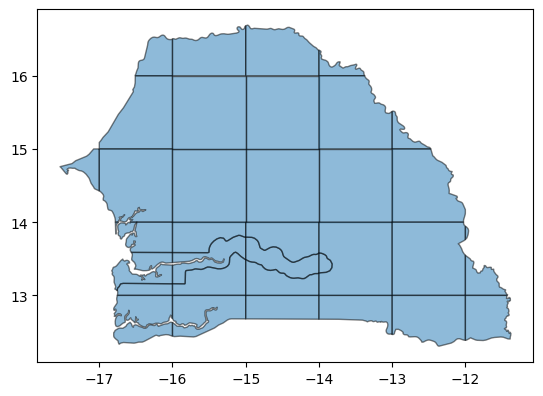

In [53]:
grid = pd.read_csv("data/grid.csv")
grid["geometry"] = grid["geometry"].apply(wkt.loads)
grid = gpd.GeoDataFrame(grid, geometry="geometry")
grid.plot(edgecolor="black", alpha=0.5)

## Load eBird data


In [54]:
usecols = [
    "SAMPLING EVENT IDENTIFIER",
    "SCIENTIFIC NAME",
    "TAXON CONCEPT ID",
    "CATEGORY",
    "LATITUDE",
    "LONGITUDE",
    "OBSERVATION DATE",
    "TIME OBSERVATIONS STARTED",
    "PROTOCOL TYPE",
    "DURATION MINUTES",
    "EFFORT DISTANCE KM",
    "ALL SPECIES REPORTED",
    "OBSERVER ID",
    "COUNTRY",
]
ebd = pd.concat(
    [
        pd.read_csv(
            "data/eBird/ebd_GM_smp_relAug-2024/ebd_GM_smp_relAug-2024.txt",
            delimiter="\t",
            usecols=usecols,
            parse_dates=["OBSERVATION DATE"],
        ),
        pd.read_csv(
            "data/eBird/ebd_SN_smp_relAug-2024/ebd_SN_smp_relAug-2024.txt",
            delimiter="\t",
            usecols=usecols,
            parse_dates=["OBSERVATION DATE"],
        ),
    ]
)

# Filter by date
ebd = ebd[ebd["OBSERVATION DATE"] >= "1990-01-01"].copy()

# Add grid name
ebd["grid_name"] = (
    "square_"
    + ebd["COUNTRY"]
    + "_lat"
    + (np.floor(ebd["LATITUDE"]) + 0.5).astype(str)
    + "N"
    + "_lon"
    + np.abs(np.floor(ebd["LONGITUDE"]) + 0.5).astype(str)
    + "E"
)

['square_Gambia_lat13.5N_lon17.5E' 'square_Gambia_lat13.5N_lon18.5E'
 'square_Senegal_lat14.5N_lon18.5E' 'square_Senegal_lat13.5N_lon17.5E'
 'square_Senegal_lat16.5N_lon17.5E' 'square_Senegal_lat15.5N_lon18.5E'
 'square_Senegal_lat15.5N_lon17.5E' 'square_Senegal_lat14.5N_lon20.5E'
 'square_Senegal_lat15.5N_lon19.5E' 'square_Senegal_lat14.5N_lon19.5E'
 'square_Senegal_lat12.5N_lon17.5E' 'square_Senegal_lat12.5N_lon18.5E'
 'square_Senegal_lat12.5N_lon19.5E']


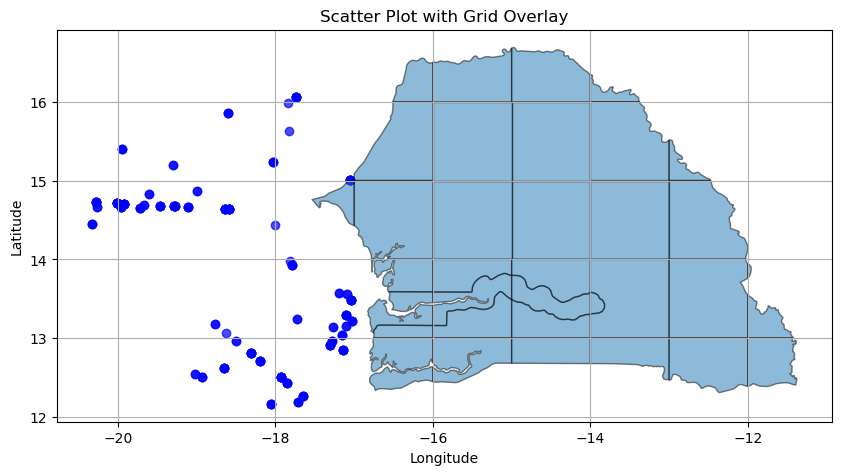

In [55]:
# Check for unique grid names in ebd that are not in grid
print(ebd.loc[~ebd["grid_name"].isin(grid["name"]), "grid_name"].unique())
ebd_out = ebd[~ebd["grid_name"].isin(grid["name"])]


geometry = [Point(xy) for xy in zip(ebd_out["LONGITUDE"], ebd_out["LATITUDE"])]
gdf = gpd.GeoDataFrame(ebd_out, geometry=geometry)

fig, ax = plt.subplots(figsize=(10, 6))

gdf.plot(ax=ax, marker="o", color="blue", figsize=(10, 6), alpha=0.7)
grid.plot(ax=ax, edgecolor="black", alpha=0.5)

# Customizing the plot
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.title("Scatter Plot with Grid Overlay")
plt.show()

# drop these location
ebd = ebd[ebd["grid_name"].isin(grid["name"])].copy()

In [56]:
# Merge ebd with sp_ebird_list, but first insure that 'SCIENTIFIC NAME' is unique
sp_ebird_list_unique = sp_ebird_list[["SCIENTIFIC NAME", "map_index"]].drop_duplicates(
    subset=["SCIENTIFIC NAME", "map_index"], keep="first"
)

duplicates = sp_ebird_list_unique[
    sp_ebird_list_unique.duplicated(subset="SCIENTIFIC NAME", keep=False)
]

assert duplicates.empty, "Duplicates found in 'SCIENTIFIC NAME'"

ebd2 = ebd.merge(sp_ebird_list_unique, on="SCIENTIFIC NAME", how="left")

assert (
    ebd2.shape[0] == ebd.shape[0]
), "Row count mismatch: ebd2 does not have the same number of rows as ebd."

ebd = ebd2

In [57]:
ebd

,CATEGORY,TAXON CONCEPT ID,SCIENTIFIC NAME,COUNTRY,LATITUDE,LONGITUDE,OBSERVATION DATE,TIME OBSERVATIONS STARTED,OBSERVER ID,SAMPLING EVENT IDENTIFIER,PROTOCOL TYPE,DURATION MINUTES,EFFORT DISTANCE KM,ALL SPECIES REPORTED,grid_name,map_index
0,species,avibase-E7C7EE3A,Coracias abyssinicus,Gambia,13.449450,-16.586752,1990-01-08,NaN,obsr1608729,S130370697,Historical,NaN,NaN,1,square_Gambia_lat13.5N_lon16.5E,345
1,species,avibase-E7C7EE3A,Coracias abyssinicus,Gambia,13.460812,-16.699154,1990-01-18,NaN,obsr1608729,S130437997,Historical,NaN,NaN,1,square_Gambia_lat13.5N_lon16.5E,345
2,species,avibase-E7C7EE3A,Coracias abyssinicus,Gambia,13.460812,-16.699154,1990-01-06,NaN,obsr1608729,S130368433,Historical,NaN,NaN,1,square_Gambia_lat13.5N_lon16.5E,345
3,species,avibase-E7C7EE3A,Coracias abyssinicus,Gambia,13.460812,-16.699154,1990-01-15,NaN,obsr1608729,S130435254,Historical,NaN,NaN,1,square_Gambia_lat13.5N_lon16.5E,345
4,species,avibase-E7C7EE3A,Coracias abyssinicus,Gambia,13.449450,-16.586752,1990-01-11,NaN,obsr1608729,S130382615,Historical,NaN,NaN,1,square_Gambia_lat13.5N_lon16.5E,345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903035,species,avibase-E70F9747,Apalis flavida,Senegal,12.420399,-16.774750,2024-08-23,10:30:00,obsr4464276,S192503077,Incidental,NaN,NaN,0,square_Senegal_lat12.5N_lon16.5E,520
903036,species,avibase-E44FAD6F,Lanius corvinus,Senegal,12.470429,-16.256892,2024-08-05,08:52:00,obsr634256,S190306964,Traveling,200.0,4.463,1,square_Senegal_lat12.5N_lon16.5E,418
903037,species,avibase-E44FAD6F,Lanius corvinus,Senegal,12.487907,-16.551236,2024-08-10,14:42:00,obsr4238839,S190891576,Traveling,28.0,0.300,0,square_Senegal_lat12.5N_lon16.5E,418
903038,species,avibase-E0D521B7,Ceuthmochares aereus,Senegal,12.551271,-16.309160,2024-08-05,17:15:00,obsr634256,S190350208,Traveling,50.0,0.981,1,square_Senegal_lat12.5N_lon16.5E,294


In [58]:
new = ebd.groupby(["grid_name", "map_index"]).size().reset_index(name="count")

### Load old atlas


In [59]:
old = (
    pd.read_csv(
        "/Users/rafnuss/Library/CloudStorage/OneDrive-Vogelwarte/Digitization-of-Oiseaux-de-Senegambie/data/gbif/occurrence.csv",
        usecols=["locality", "scientificName"],
    )
    .merge(
        pd.read_excel(
            "/Users/rafnuss/Library/CloudStorage/OneDrive-Vogelwarte/Digitization-of-Oiseaux-de-Senegambie/data/gbif/sp_list_gbif.xlsx",
            usecols=["scientificName", "map_index"],
        )
    )
    .drop(columns="scientificName")
    .rename(columns={"locality": "grid_name"})
)
old["map_index"] = old["map_index"].fillna(0).astype(int)

In [60]:
old.drop_duplicates(inplace=True)

In [61]:
# Check for unique grid names in ebd that are not in grid
old.loc[~old["grid_name"].isin(grid["name"]), "grid_name"].unique()

array([], dtype=object)

## Plot Spatial difference


In [62]:
grid2 = grid.merge(
    old.groupby("grid_name")
    .agg(old_number_species=("map_index", "size"))
    .reset_index(),
    right_on="grid_name",
    left_on="name",
    how="left",
)
grid2 = grid2.merge(
    new.groupby("grid_name")
    .agg(
        new_number_species=("map_index", "size"), new_number_sightings=("count", "sum")
    )
    .reset_index(),
    right_on="grid_name",
    left_on="name",
    how="left",
)

grid2 = gpd.GeoDataFrame(grid2, geometry=grid2["geometry"])

In [63]:
def plot_grid(gdf, column, cmap, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the column data
    gdf.plot(column=column, cmap=cmap, legend=True, ax=ax, edgecolor="black")

    # Add annotations
    for idx, row in gdf.iterrows():
        # Calculate centroid for annotation
        centroid = row.geometry.centroid

        # Handle NaN values by skipping or using a placeholder
        value = row[column]
        if pd.isna(value):
            annotation_text = "0"  # Use "NaN" or skip this annotation
        else:
            annotation_text = str(int(value))

        ax.text(
            centroid.x,
            centroid.y,
            annotation_text,
            fontsize=12,
            color="white",
            ha="center",
            va="center",
            bbox=dict(facecolor="black", edgecolor="none", alpha=0.7),
        )

    # Set axis labels
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"Plot of {column}")

    return ax

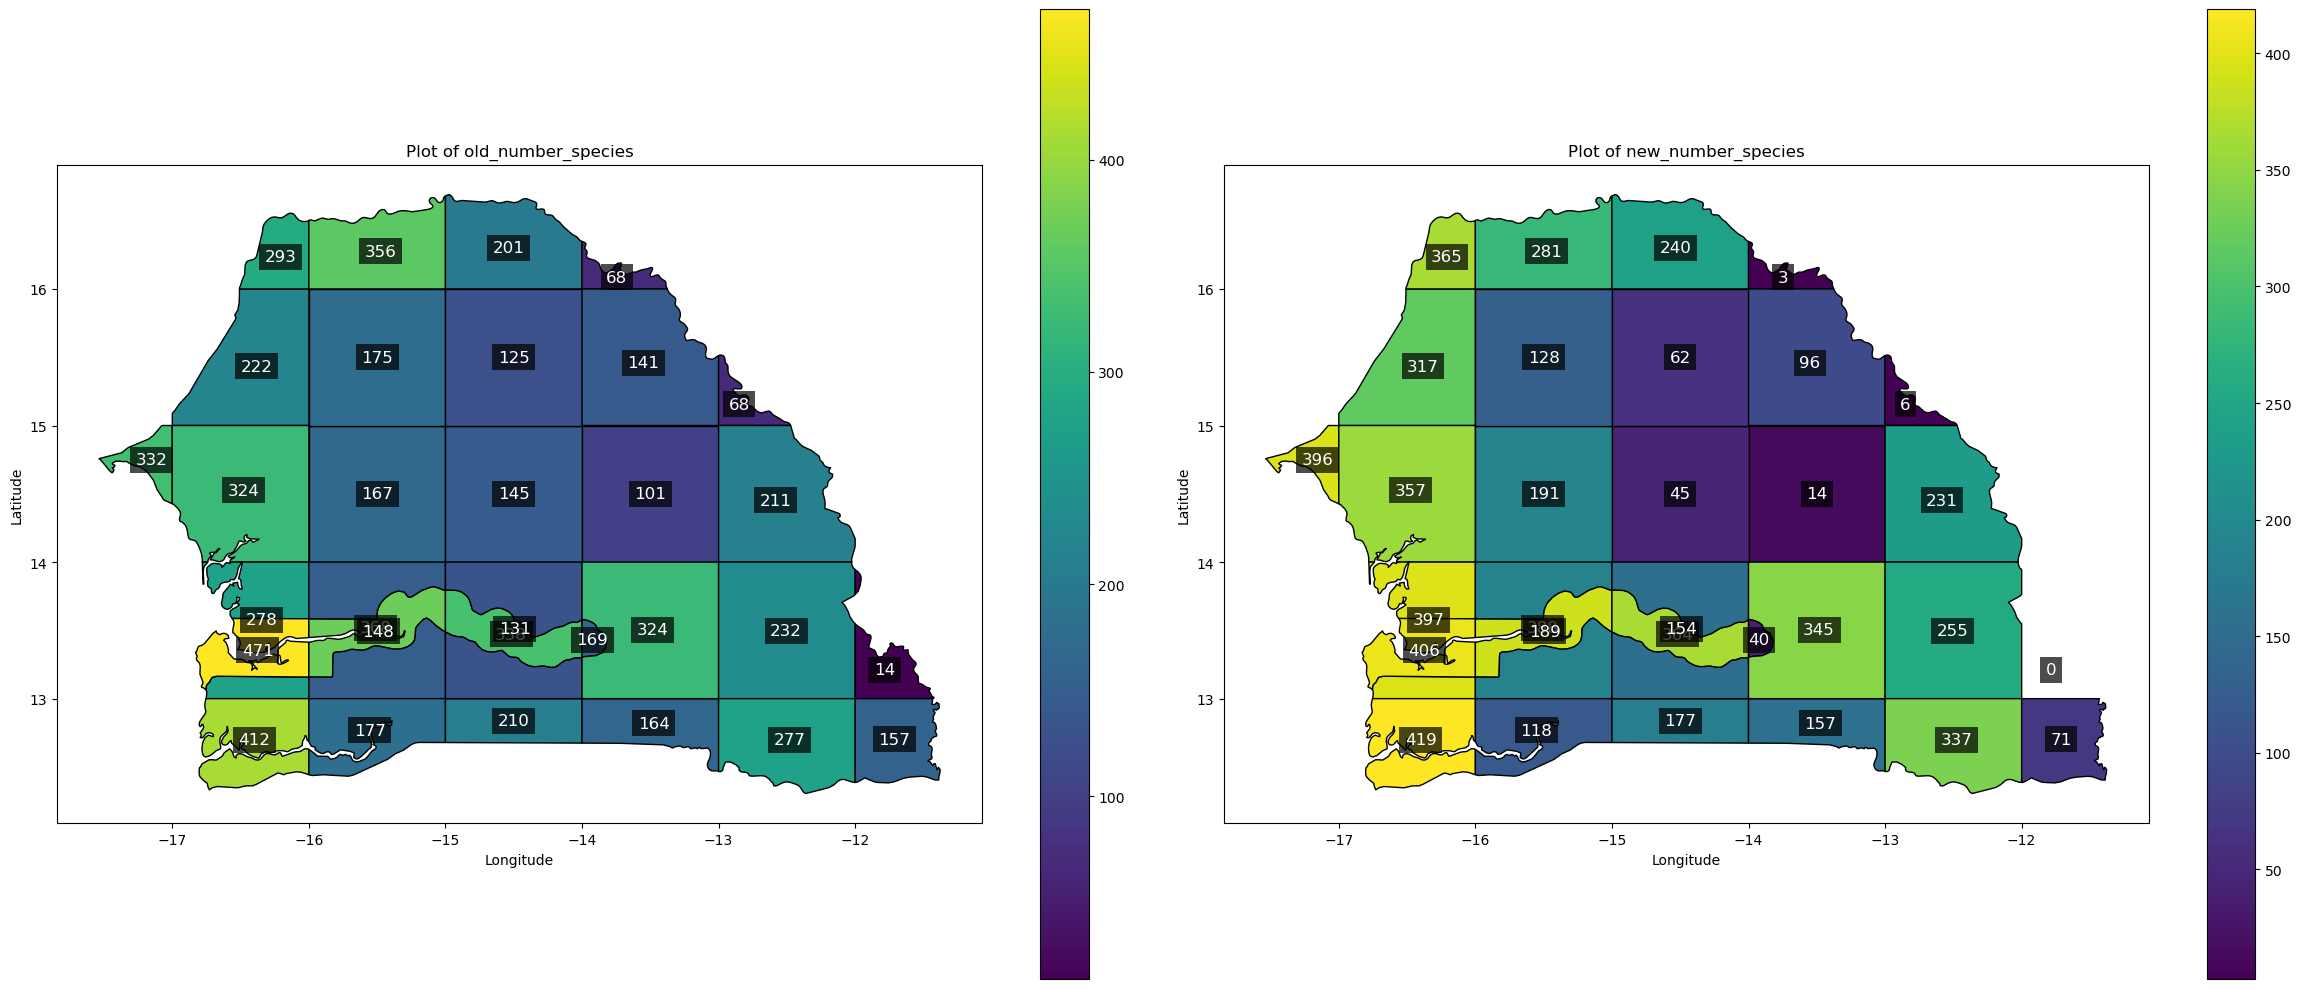

In [64]:
# Usage example
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Plot 'count' on ax1
plot_grid(grid2, "old_number_species", "viridis", ax1)

# Plot 'unique_scientific_name_count' on ax2
plot_grid(grid2, "new_number_species", "viridis", ax2)

plt.tight_layout()
plt.show()

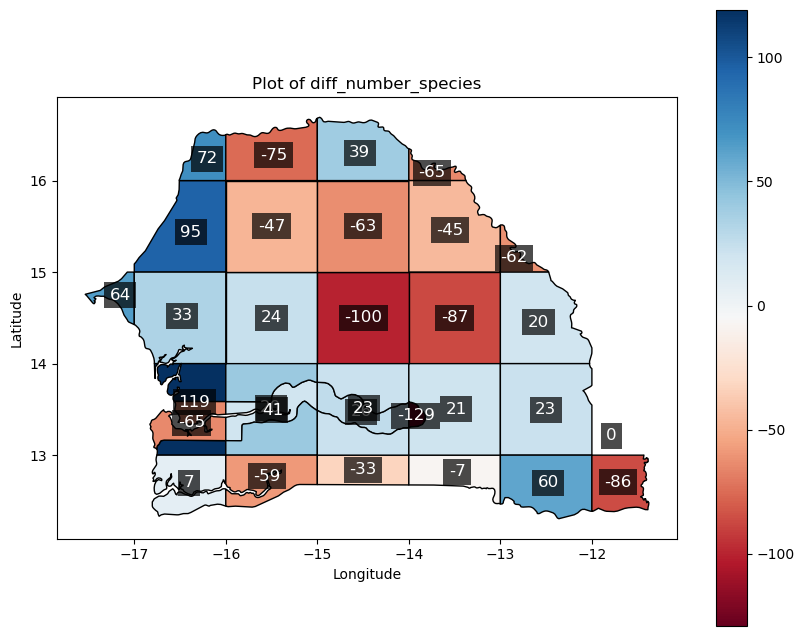

In [65]:
grid2["diff_number_species"] = grid2["new_number_species"] - grid2["old_number_species"]
plot_grid(grid2, "diff_number_species", "RdBu")
plt.show()

## Species difference


In [74]:
old[old["map_index"] == 12]

,grid_name,map_index


In [158]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colormaps


def plot_grid(map_index, type="diff", ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    gdf = grid

    cmap = ListedColormap(["grey", "green"])

    if type == "diff" or type == "new":
        gdf = gdf.merge(
            new[new["map_index"] == map_index].rename(columns={"map_index": "new"}),
            right_on="grid_name",
            left_on="name",
            how="left",
        )
        gdf["new"] = ~gdf["new"].isna()
        value = "new"

    if type == "diff" or type == "old":
        gdf = gdf.merge(
            old[old["map_index"] == map_index].rename(columns={"map_index": "old"}),
            right_on="grid_name",
            left_on="name",
            how="left",
        )
        gdf["old"] = ~gdf["old"].isna()
        value = "old"

    if type == "diff":
        gdf["diff"] = "never"
        gdf.loc[gdf["new"] & gdf["old"], "diff"] = "kept"
        gdf.loc[gdf["new"] & ~gdf["old"], "diff"] = "gained"
        gdf.loc[~gdf["new"] & gdf["old"], "diff"] = "lost"
        gdf["diff"] = pd.Categorical(
            gdf["diff"], categories=["never", "lost", "kept", "gained"], ordered=True
        )
        value = "diff"
        rd_yl_gn = colormaps["RdYlGn"]
        colors = [rd_yl_gn(0.2), rd_yl_gn(0.5), rd_yl_gn(0.8)]
        cmap = ListedColormap([[0.5, 0.5, 0.5]] + colors)

    # Plot the column data
    gpd.GeoDataFrame(gdf, geometry=gdf["geometry"]).plot(
        column=value, cmap=cmap, ax=ax, edgecolor="black", legend=True
    )

    # Set axis labels
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(
        f'Plot of {sp_base_list.loc[sp_base_list["map_index"] == map_index, "clements_common_name"].iat[0]}'
    )

    return ax

<Axes: title={'center': "Plot of Cory's Shearwater"}, xlabel='Longitude', ylabel='Latitude'>

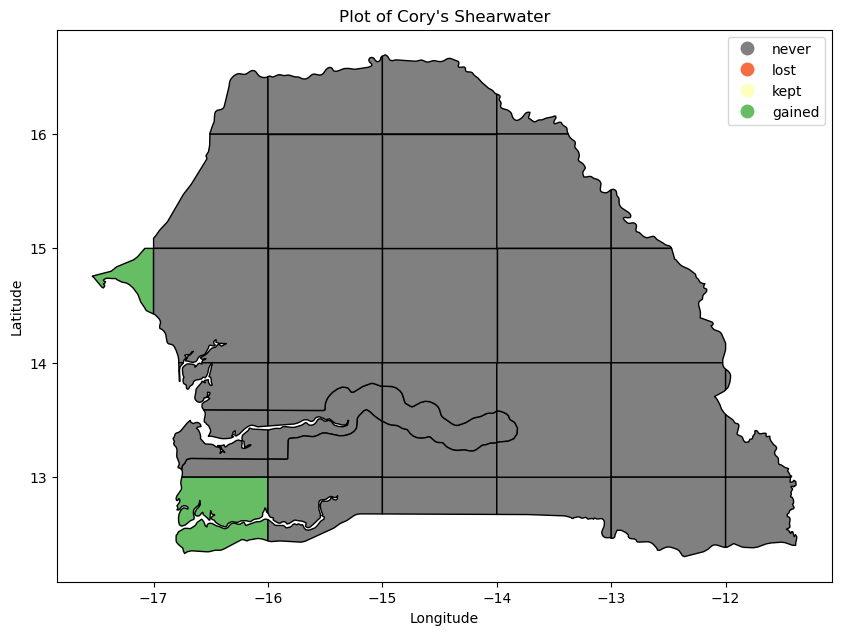

In [159]:
plot_grid(map_index=5)

In [160]:
import os
import matplotlib.pyplot as plt

# Ensure the directory exists
output_dir = "data/plot_diff/"
os.makedirs(output_dir, exist_ok=True)

# Iterate over your list and save plots
for i in sp_base_list["map_index"]:
    plot_grid(map_index=i)
    sp_name = sp_base_list.loc[
        sp_base_list["map_index"] == i, "clements_common_name"
    ].iat[0]
    file_name = f'{i}_{sp_name.replace("/", "_")}.png'
    file_path = os.path.join(output_dir, file_name)
    plt.savefig(file_path)  # Save the plot as a PNG file
    plt.close()

In [161]:
sp = (
    sp_base_list.merge(
        new.groupby("map_index").size().reset_index(name="new_number_of_square"),
        how="left",
    )
    .merge(
        old.groupby("map_index").size().reset_index(name="old_number_of_square"),
        how="left",
    )
    .sort_values("sort v2023")
)
sp["new_number_of_square"] = sp["new_number_of_square"].fillna(0).astype(int)
sp["old_number_of_square"] = sp["old_number_of_square"].fillna(0).astype(int)

sp["diff_number_of_square"] = sp["new_number_of_square"] - sp["old_number_of_square"]
sp = sp.sort_values("diff_number_of_square", ascending=False)

In [162]:
sp.to_csv("data/sp.csv", index=False)